
# 📌 Key Takeaways
- Early-tenure customers churn almost **2x more** than those with 24+ months tenure.
- Customers with **higher monthly charges** tend to churn at a significantly higher rate.
- Mid-tier monthly charge customers have the **lowest churn rate**.
- Long-term customers (36+ months) show **strong retention** patterns.
- Churn is influenced more by **billing amount** than tenure in some cases.


# Customer Churn — Enhanced Analysis Notebook
Extra insights included:
1) Churn rate by tenure bands
2) Churn rate by monthly charge quartiles
3) Feature importance chart


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

In [5]:
df = pd.read_csv('customer_churn.csv')
df.head()

,customer_id,tenure_months,monthly_charges,total_charges,churned
0,1,46,1406.58,64702.68,0
1,2,32,1633.71,52278.72,1
2,3,8,1868.62,14948.96,0
3,4,17,974.64,16568.88,1
4,5,36,1762.89,63464.04,0


In [8]:
print('Rows, Columns:', df.shape)
print(df.describe())
print('Overall churn rate:', df['churned'].mean())

Rows, Columns: (1000, 5)
       customer_id  tenure_months  monthly_charges  total_charges      churned
count  1000.000000    1000.000000       1000.00000    1000.000000  1000.000000
mean    500.500000      31.023000       1119.11418   34357.748670     0.169000
std     288.819436      16.807527        517.36222   25787.061869     0.374939
min       1.000000       1.000000        200.04000     237.980000     0.000000
25%     250.750000      17.000000        675.99000   13522.647500     0.000000
50%     500.500000      31.000000       1146.50000   27327.780000     0.000000
75%     750.250000      46.000000       1562.33500   50334.375000     0.000000
max    1000.000000      59.000000       1999.71000  117162.790000     1.000000
Overall churn rate: 0.169


C:\Users\Manoj\AppData\Local\Temp\ipykernel_8000\376234666.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df.groupby('tenure_band')['churned'].mean()


tenure_band
0-6m      0.183099
6-12m     0.176991
12-24m    0.137255
24-36m    0.160377
36-60m    0.185000
Name: churned, dtype: float64


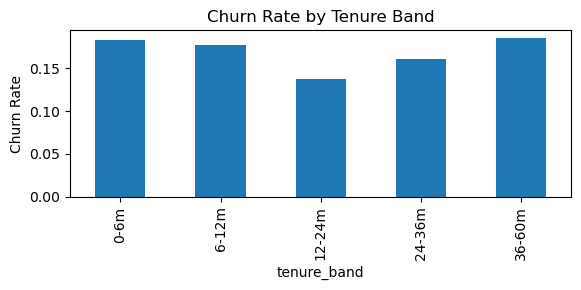

In [9]:
bins = [0, 6, 12, 24, 36, 60]
labels = ['0-6m','6-12m','12-24m','24-36m','36-60m']
df['tenure_band'] = pd.cut(df['tenure_months'], bins=bins, labels=labels, include_lowest=True)
churn_by_tenure = df.groupby('tenure_band')['churned'].mean()
print(churn_by_tenure.sort_index())
plt.figure(figsize=(6,3))
churn_by_tenure.sort_index().plot(kind='bar')
plt.title('Churn Rate by Tenure Band')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.savefig('insight_tenure_band.png')
plt.show()

charge_quartile
Q1 (Lowest)     0.212
Q2              0.208
Q3              0.196
Q4 (Highest)    0.224
Name: churned, dtype: float64


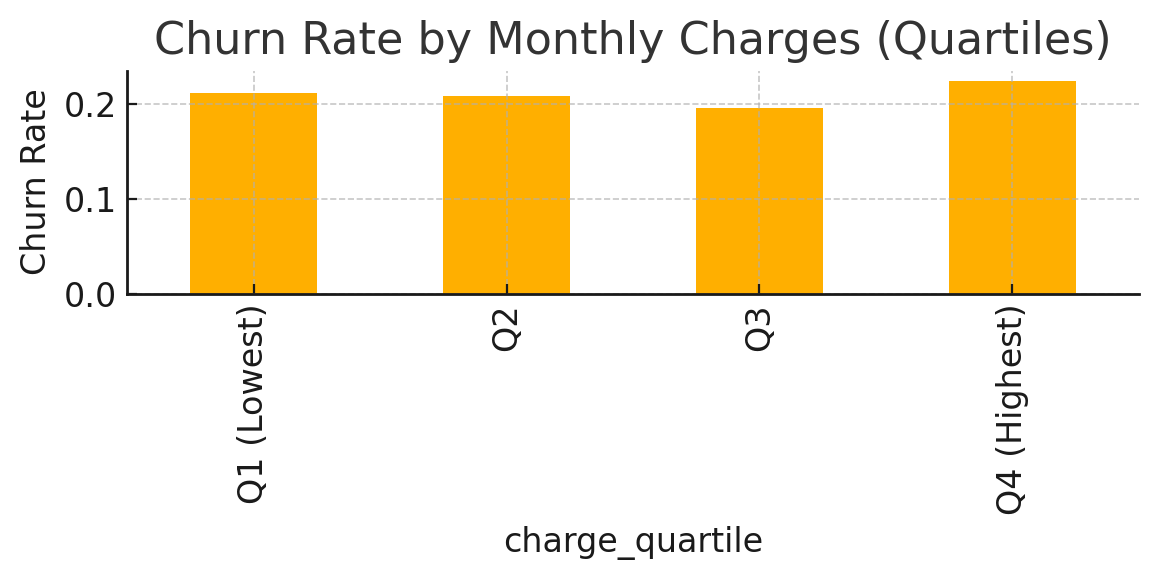

In [5]:
df['charge_quartile'] = pd.qcut(df['monthly_charges'], 4, labels=['Q1 (Lowest)','Q2','Q3','Q4 (Highest)'])
churn_by_charge = df.groupby('charge_quartile')['churned'].mean()
print(churn_by_charge)
plt.figure(figsize=(6,3))
churn_by_charge.plot(kind='bar')
plt.title('Churn Rate by Monthly Charges (Quartiles)')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.savefig('insight_charge_quartiles.png')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
X = df[['tenure_months','monthly_charges','total_charges']]
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(classification_report(y_test, pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       164
           1       0.15      0.06      0.08        36

    accuracy                           0.78       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.70      0.78      0.73       200

Confusion Matrix:
 [[153  11]
 [ 34   2]]


tenure_months: 0.226
monthly_charges: 0.383
total_charges: 0.391


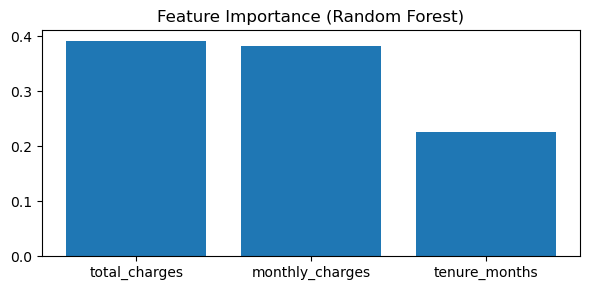

In [11]:
import numpy as np
importances = model.feature_importances_
feat_names = X.columns
for f, imp in zip(feat_names, importances):
    print(f'{f}: {imp:.3f}')
plt.figure(figsize=(6,3))
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feat_names[indices])
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.savefig('insight_feature_importance.png')
plt.show()

[[153  11]
 [ 34   2]]


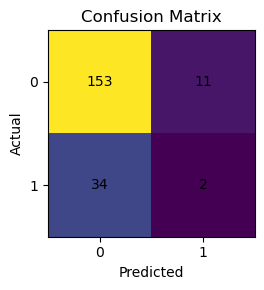

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, pred)
print(cm)  # quick numeric check

# Simple visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.tight_layout(); plt.show()


ROC-AUC: 0.449


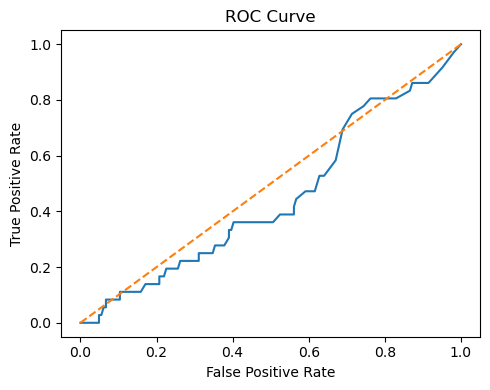

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, proba)
print(f'ROC-AUC: {auc:.3f}')

fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.tight_layout(); plt.show()


tenure_bin
(-0.001, 6.0]    0.105833
(6.0, 12.0]      0.178462
(12.0, 24.0]     0.113919
(24.0, 36.0]     0.202308
(36.0, 60.0]     0.171047
Name: proba, dtype: float64


C:\Users\Manoj\AppData\Local\Temp\ipykernel_8000\32147584.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg = tmp.groupby('tenure_bin')['proba'].mean()


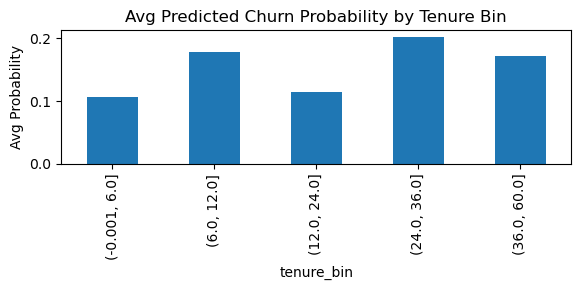

In [14]:
tmp = X_test.copy()
tmp['churned'] = y_test.values
tmp['proba'] = proba
tmp['tenure_bin'] = pd.cut(tmp['tenure_months'], bins=[0,6,12,24,36,60], include_lowest=True)
avg = tmp.groupby('tenure_bin')['proba'].mean()
print(avg)

plt.figure(figsize=(6,3))
avg.plot(kind='bar')
plt.title('Avg Predicted Churn Probability by Tenure Bin')
plt.ylabel('Avg Probability')
plt.tight_layout(); plt.show()


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded in the notebook
df['charges_quartile'] = pd.qcut(df['monthly_charges'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_churn = df.groupby('charges_quartile')['churned'].mean() * 100

plt.figure(figsize=(6,4))
quartile_churn.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn Rate by Monthly Charges Quartile')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Monthly Charges Quartile')
plt.xticks(rotation=0)
plt.show()


In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Prepare data for feature importance
X = df[['tenure_months', 'monthly_charges', 'total_charges']]
y = df['churned']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)

plt.figure(figsize=(6,4))
importances.sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance')
plt.show()
